In [1]:
# ------------------------------------------------------------------------------------------------
# VGG16 model to build shared CNN layer
# Original: .py file [Here is just a presentation]
# Reference:
# Very Deep Convolutional Networks for Large-Scale Image Recognition]
#(https://arxiv.org/abs/1409.1556)
# ------------------------------------------------------------------------------------------------

In [2]:
cd ..

/Users/zehaodong/Desktop/faster-rcnn-keras


### Imoport Libraries

In [3]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras_frcnn.RoiPoolingConv import RoiPoolingConv

Using TensorFlow backend.


### shared CNN: VGG16

In [4]:
def nn_base(input_tensor=None, trainable=False):
    """13th layer"""
    ###### Determine proper input shape: theano or tensorflow #####
    if K.image_dim_ordering() == 'th':
        input_shape = (3, None, None)
    else:
        input_shape = (None, None, 3)

    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    ###### Block 1 ######
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    ###### Block 2 ######
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    ###### Block 3 ######
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    ###### Block 4 ######
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    ###### Block 5 ######
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)

    return x


### structure functions

In [5]:
"""
Funtions to build faster rcnn model in the training process 
and rebuild corresponding faster rcnn model in the test process
"""

'\nFuntions to build faster rcnn model in the training process \nand rebuild corresponding faster rcnn model in the test process\n'

In [6]:
def rpn(base_layers, num_anchors):
    """
    Used for testing
    inputs:
        base_layers: feature map, output from shared CNN (raw feature extraction net)
        num_anchors: in faster rcnn, equals to 3 x 3
    output: 
        x_cls: 9-d, used to build cls_loss, cross entropy
        x_regr: 4x9-d, used to build regr_loss, smooth L1
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_cls = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_cls, x_regr, base_layers]

In [7]:
def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):
    """
    Used in training process and test process
    Inputs:
        base_layers: feature map, output from shared CNN (raw feature extraction net)
        input_rois: roipooling layer
        num_rois: number of rois
    Outputs:
        out_cls: inputs for cross entropy loss
        out_regr: inputs for smooth L1 loss
    """
    if K.backend() == 'tensorflow':
        pooling_regions = 7
        input_shape = (num_rois,7,7,512)
    elif K.backend() == 'theano':
        pooling_regions = 7
        input_shape = (num_rois,512,7,7)

    ##### Roipooling layer #####
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    ##### fully connected and relu layer + dropout layer #####
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    ##### output layer #####
    """no regression output for background, bg """
    out_cls = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_cls, out_regr]

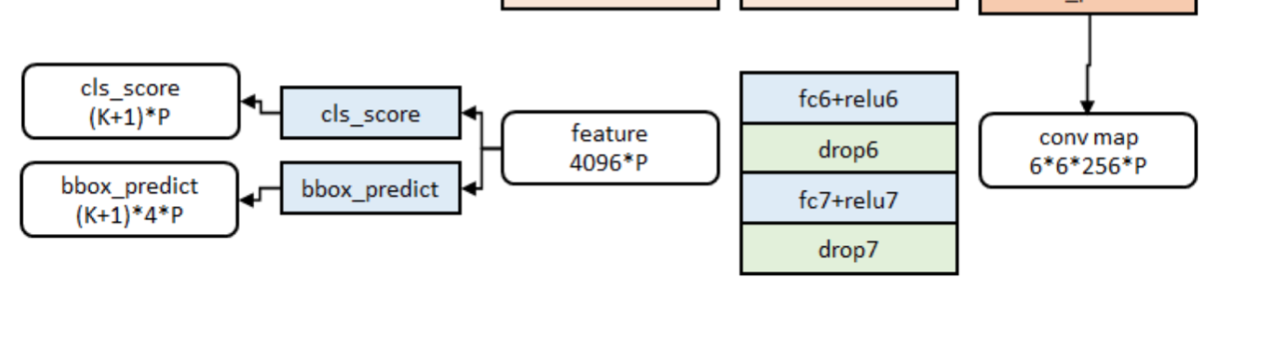

In [8]:
####### Visulization ########
from PIL import Image
Image.open('/Users/zehaodong/Desktop/AML_Final/keras-frcnn-master/vgg_fastrcnn.png')

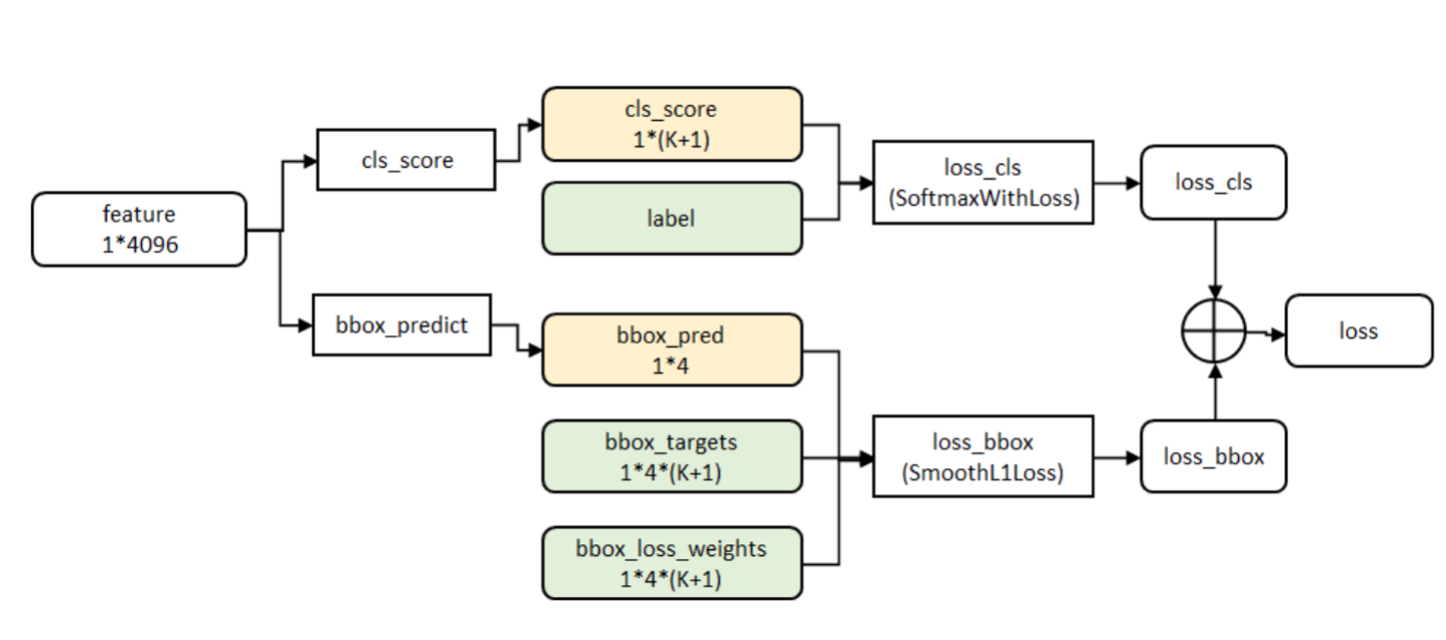

In [9]:
Image.open('/Users/zehaodong/Desktop/AML_Final/keras-frcnn-master/vgg_classifier.png')

In [10]:
def get_weight_path():
    if K.image_dim_ordering() == 'th':
        print('pretrained weights not available for VGG with theano backend')
        return
    else:
        return 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'



In [11]:
def get_img_output_length(width, height):
    """
    why:/16
    based on the vgg net: 5 pooling with strides = (2,2), each dim x 1/2
                          all padding = 'same', each conv dim do not change
                          so 16 =2^4
    """
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height) 